# Segmentación de la señal para calcular biomarcadores de antisácadas

In [1]:
%matplotlib inline

import bsp.core
from bsp.core import load_study
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [14, 8]


study = load_study("data/20240420-rbg-antisaccade.bsp")
antisacade = study[1]

## Investigando direfencias de impulses y saccades
- Impulses: Utiliza KMeans --> separa movimientos rápidos de los lentos
- Saccades: Identifica las sácadas a partir de la velocidad y teniendo en cuenta la amplitud

In [2]:
from bsp.core import impulses
c = 0
for start, end in impulses(antisacade.hor_channel):
    print("Impulso:", start/1000, end/1000) #segundos
    print("Len(impulso): " , len(antisacade.hor_channel[start:end]))
    print(antisacade.hor_channel[start:end])
    c += 1
print("Total impulsos: ", c)

Impulso: 2.153 2.183
Len(impulso):  30
[-0.25543213 -0.25543213 -0.25543213 -0.56892014 -0.88240814 -1.1175232
 -1.352642   -1.5877571  -1.9012451  -2.1363602  -2.293106   -2.3714752
 -2.3714752  -2.3714752  -2.5282211  -2.6849632  -2.920082   -3.23357
 -3.3903122  -3.547058   -3.7821732  -4.174034   -4.644264   -5.114498
 -5.663101   -6.054962   -6.446823   -6.760311   -6.917053   -7.230541  ]
Impulso: 2.188 2.199
Len(impulso):  11
[ -7.622402  -7.622402  -7.779148  -8.249378  -8.641239  -8.954727
  -9.346586  -9.738447 -10.130308 -10.365423 -10.60054 ]
Impulso: 3.693 3.787
Len(impulso):  94
[-0.72566605 -0.6472931  -0.56892014 -0.56892014 -0.41217804 -0.41217804
 -0.41217804 -0.33380508 -0.25543213  0.05805588  0.44991684  0.92014694
  1.4687538   1.9389839   2.4092178   2.801075    2.879448    2.957821
  3.0361938   3.192936    3.506424    3.819912    4.1334      4.368519
  4.446888    4.603634    4.760376    5.152237    5.622471    6.171074
  6.79805     7.425026    8.052002    8.5

In [3]:
from bsp.core.saccades import saccades
total_sacadas = 0
for onset, offset in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    total_sacadas += 1
    print("Saccade onset:", onset, "Saccade offset:", offset)
print("Total sacadas" , total_sacadas)

Saccade onset: 3691 Saccade offset: 3787
Saccade onset: 5443 Saccade offset: 5522
Saccade onset: 7325 Saccade offset: 7428
Saccade onset: 9156 Saccade offset: 9253
Saccade onset: 10836 Saccade offset: 10931
Saccade onset: 12641 Saccade offset: 12738
Saccade onset: 14360 Saccade offset: 14461
Saccade onset: 16174 Saccade offset: 16297
Saccade onset: 17877 Saccade offset: 17974
Saccade onset: 19550 Saccade offset: 19663
Saccade onset: 21242 Saccade offset: 21332
Saccade onset: 23004 Saccade offset: 23100
Saccade onset: 24753 Saccade offset: 24861
Saccade onset: 26596 Saccade offset: 26701
Saccade onset: 28402 Saccade offset: 28514
Saccade onset: 31834 Saccade offset: 31956
Saccade onset: 33630 Saccade offset: 33744
Saccade onset: 35335 Saccade offset: 35450
Total sacadas 18


## Detectar antisácadas por su amplitud
Es antisácada aquella que tenga una amplitud mayor que (amplitude_stimuli-1)/2.  
Me he ido fijando en las amplitudes de las antisácadas.  
Un par de antisácadas no las detecta porque son "raras" -> ¿Qué hago con ellas?

In [4]:
from bsp.core.differentiation import differentiate
from bsp.core.impulses import impulses

import numpy as np
from enum import Enum
from numpy import ndarray

def antisaccades(channel: np.ndarray, stimuli: np.ndarray) -> list[tuple[int, int]]:
    list = []
    samples_to_remove = 100
    stimuli = stimuli.copy()[:-samples_to_remove]
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))
    c = 0
            
    for start, end in impulses(channel):
        if max(channel[start:end]) >= 0 and  min(channel[start:end]) >= 0:
            amplitude_channel = max(channel[start:end]) - min(channel[start:end])
        elif max(channel[start:end]) < 0 and min(channel[start:end]) < 0:
            amplitude_channel = abs(max(channel[start:end]) - min(channel[start:end]))
        else:
            amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
            
        if amplitude_channel > (amplitude_stimuli-1)/2:
            list.append((start, end))
            c += 1
    print(c)
    return list


17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]
17


Text(0.5, 0, 'Tiempo (s)')

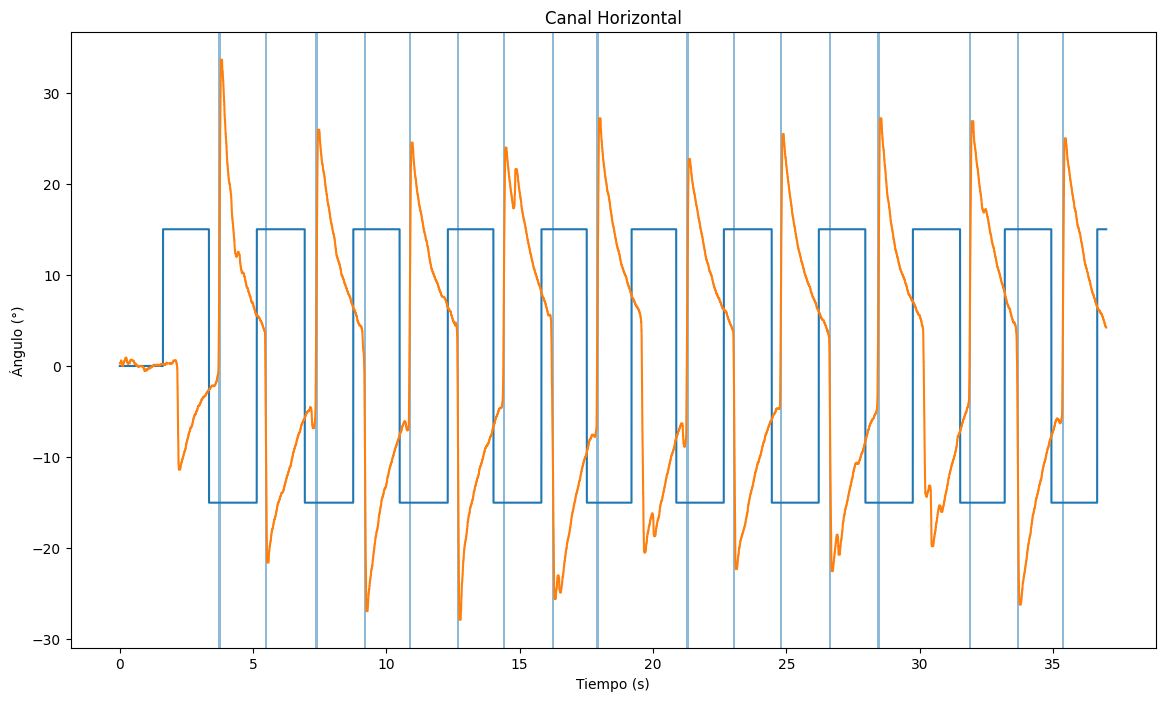

In [5]:
#from bsp.core.biomarkers import antisaccades

resultados = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(resultados)

time = np.arange(len(antisacade.hor_stimuli)) / 1000.0  # segundos

plt.title("Canal Horizontal")
for start, end in antisaccades(antisacade.hor_channel, antisacade.hor_stimuli):
    plt.axvspan((start)/1000, (end)/1000, alpha=0.5)
plt.plot(time[0:37000], antisacade.hor_stimuli[0:37000])
plt.plot(time[0:37000], antisacade.hor_channel[0:37000])
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")

## Detección sácadas

## Dirección
| Celda 1 | Stimuli + | Stimuli - |
|---------|---------|---------|
| Channel + | Sácada Derecha | Antisácada Derecha |
| Channel - | Antisácada Izq | Sácada Izq |

In [6]:
class Direction(Enum):
    Left = "left"
    Right = "right"
    
def direction(channel: np.ndarray, stimuli: np.ndarray, start: int, end: int) -> Direction:
    if channel[end] > 0:
        if stimuli[end] > 0:
            # Sacada Derecha
            return Direction.Right
        elif stimuli[end] < 0:
            # Antisácada Derecha
            return Direction.Right
    elif channel[end] < 0:
        if stimuli[end] > 0:
            # Antisácada Izquierda
            return Direction.Left
        elif stimuli[end] < 0:
            # Sácada Izquierda
            return Direction.Left
        

In [7]:
direccion = direction(antisacade.hor_channel, antisacade.hor_stimuli, 3691, 5522)
print(direccion)

Direction.Left


## Latencia antisacádica
$$\text{Latencia antisacádica} = (X_{\text{inicio antisácada}} - X_{\text{inicio estímulo}}) \times \text{Intervalo de muestras}$$

In [9]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
    change_indices = []
    for i in range(1, len(stimuli)):
        if stimuli[i] != stimuli[i - 1]:
            change_indices.append(i)
    return change_indices

# Ejemplo de uso
estimulo = np.array([0, 15, 15, -15, -15, -15, 15, 15, 15])
cambios = detect_changes(antisacade.hor_stimuli)
print("Cambios en los índices:", cambios)

Cambios en los índices: [1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


In [10]:
movements = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(movements)

17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]


In [11]:
def antisaccade_latencies_biomarker(stimuli: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    
    def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices
    
    latencies = []
    samples_interval = 1/1000
    stimuli_changes = detect_changes(stimuli)
    for start, end in movements:
        last_stimuli = max(change for change in stimuli_changes if change < start)
        latency = (start - last_stimuli) * samples_interval
        latencies.append(latency)
    return latencies
    

In [12]:
latencias = antisaccade_latencies_biomarker(antisacade.hor_stimuli, movements)
print(latencias)

[0.35100000000000003, 0.308, 0.401, 0.41400000000000003, 0.342, 0.352, 0.366, 0.417, 0.365, 0.371, 0.353, 0.31, 0.381, 0.456, 0.332, 0.461, 0.396]


In [13]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices

In [14]:
stimuli_changes = detect_changes(antisacade.hor_stimuli)
print(stimuli_changes)

[1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


## Latencia antisacádica correctora
$$\text{Latencia antisacádica} = (X_{\text{inicio antisácada}} - X_{\text{fin sácada inapropiada}}) \times \text{Intervalo de muestras}$$

In [15]:
def antisaccade_correction_latencies_biomarker(saccades_movements: list[tuple[int, int]], antisaccades_movements: list[tuple[int, int]]) -> list[float]:
    

SyntaxError: incomplete input (4211085578.py, line 2)

## Duración
$$\text{Duración} = (X_{\text{fin antisácada}} - X_{\text{inicio antisácada}}) \times \text{Intervalo de muestras}$$

In [36]:
def antisaccade_durations_biomarker(movements: list[tuple[int, int]]) -> list[float]:
    durations = []
    samples_interval = 1/1000
    for start, end in movements:
        duration = (end - start) * samples_interval
        durations.append(duration)
    return durations

In [37]:
durations = antisaccade_durations_biomarker(movements)
print(durations)

[0.094, 0.079, 0.093, 0.08, 0.094, 0.07100000000000001, 0.073, 0.063, 0.10200000000000001, 0.092, 0.08, 0.091, 0.091, 0.08, 0.09, 0.057, 0.084]


## Velocidad máxima
No aplico filtro a la velocidad , debería?

In [18]:
from bsp.core.differentiation import differentiate

def antisaccade_velocities_biomarker(channel: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    velocities = []
    for start, end in movements:
        velocidad_max = max(abs(differentiate(channel[start:end])))
        velocities.append(velocidad_max)
    return velocities

In [19]:
velocities = antisaccade_velocities_biomarker(antisacade.hor_channel, movements)
print(velocities)

[682.4516809162653, 586.6943372713102, 600.7606570074146, 598.4162947144172, 543.0628295637604, 736.8616691002478, 596.1022995753907, 513.1020523729302, 585.7498595764587, 624.2512345036149, 579.4933981550879, 555.6984999981979, 536.5926643258949, 527.8693156920391, 567.0860908526085, 593.8494229557539, 528.6759818906272]


## Location in memory
$$\text{Precisión de la localización del estímulo en memoria} = \frac{\text{Amplitud del estímulo}-\text{Amplitud de la antisácada}}{\text{Amplitud del estímulo}}$$

$$\text{Amplitud de la antisácada} = \left| Y_{\text{fin antisácada}} - Y_{\text{inicio antisácada}} \right|$$

In [34]:
def antisaccade_location_memory_biomarker(channel: np.ndarray, stimuli: np.ndarray, antisaccades_movements:list[tuple[int, int]]) -> list[float]:
    accuracy_locations_memory = []
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))

    for start, end in antisaccades_movements:
        amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
        location_memory = (amplitude_stimuli - amplitude_channel)/amplitude_stimuli
        accuracy_locations_memory.append(location_memory)
    return accuracy_locations_memory

In [35]:
loc = antisaccade_location_memory_biomarker(antisacade.hor_channel, antisacade.hor_stimuli, movements)
print(loc)

[0.16930428, 0.5514274, 0.48219022, 0.32868114, 0.5534808, 0.43459022, 0.4425844, 0.5425527, 0.48615095, 0.6247713, 0.5613288, 0.47228876, 0.5435062, 0.4663479, 0.4663479, 0.48805806, 0.59704715]
